In [1]:
library("stats")
library("forecast")
library("MLmetrics")
library("itsmr")
library("tseries")


Attaching package: ‘MLmetrics’

The following object is masked from ‘package:base’:

    Recall


Attaching package: ‘itsmr’

The following object is masked from ‘package:forecast’:

    forecast


Attaching package: ‘tseries’

The following object is masked from ‘package:itsmr’:

    arma



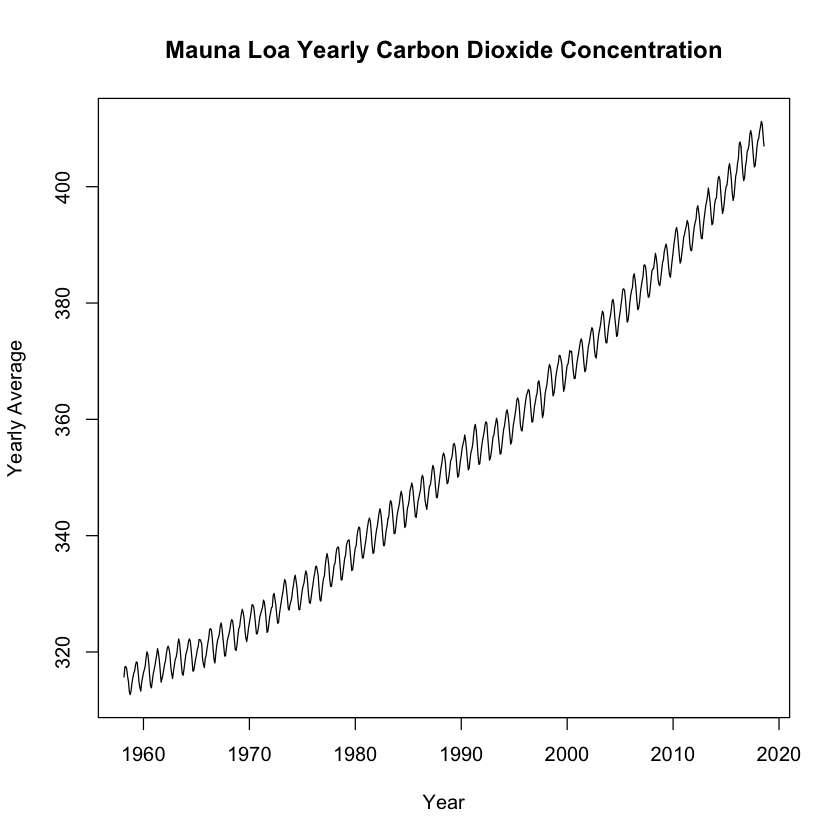

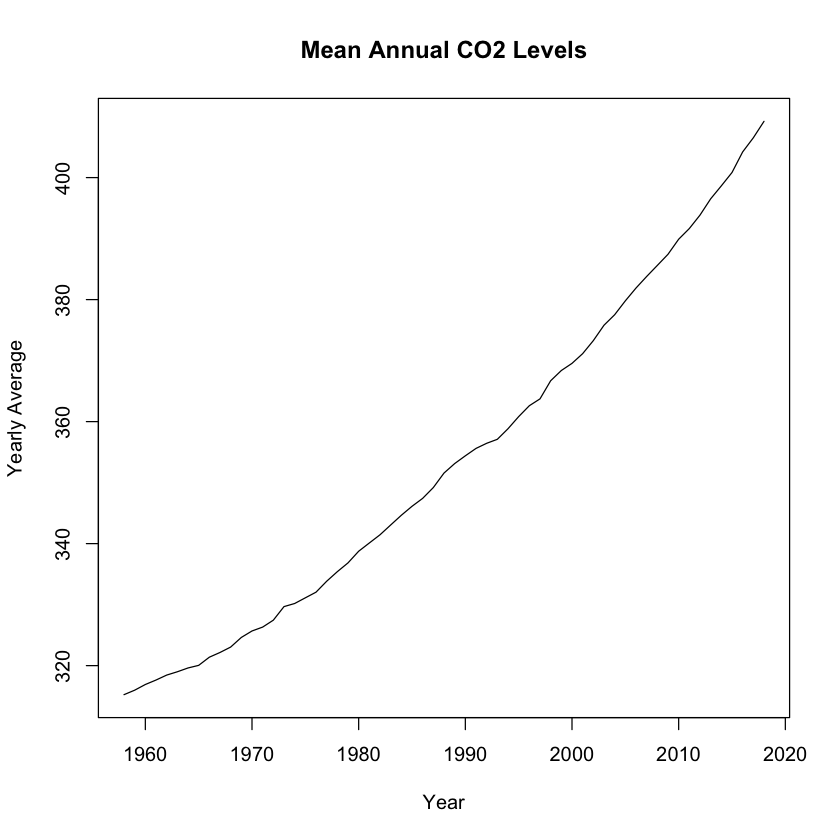

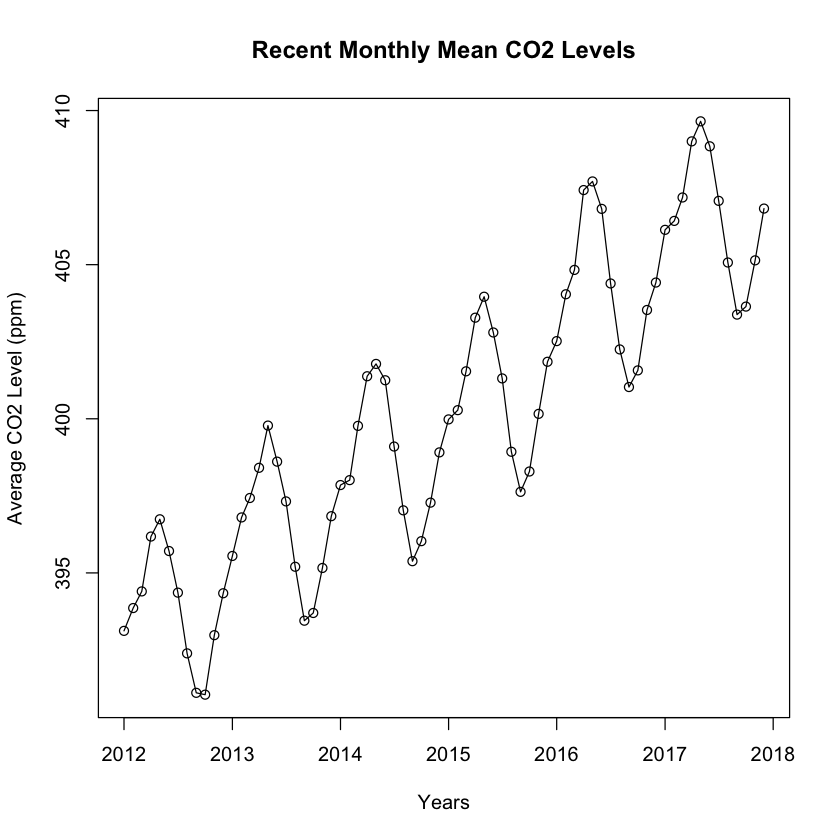

In [2]:
df = read.table("co2_mm_mlo.txt", col.names = c("Year", "Month", "Date", "average", "interpolated", "trend", "days"))
df[,8] = as.Date(paste(df$Year, df$Month, 1, sep = "-"), format = "%Y-%m-%d")
plot(df[,8], df[,5], type = "l", xlab = "Year", ylab = "Yearly Average", 
     main = "Mauna Loa Yearly Carbon Dioxide Concentration")
plot(1958:2018, tapply(df[,5], format(df[,8], "%Y"), mean), xlab = "Year", 
     ylab = "Yearly Average", main = "Mean Annual CO2 Levels", type = "l")
plot(df[647:718, 8], df[647:718, 4], type = "o", xlab = "Years", 
     ylab = "Average CO2 Level (ppm)", main = "Recent Monthly Mean CO2 Levels")

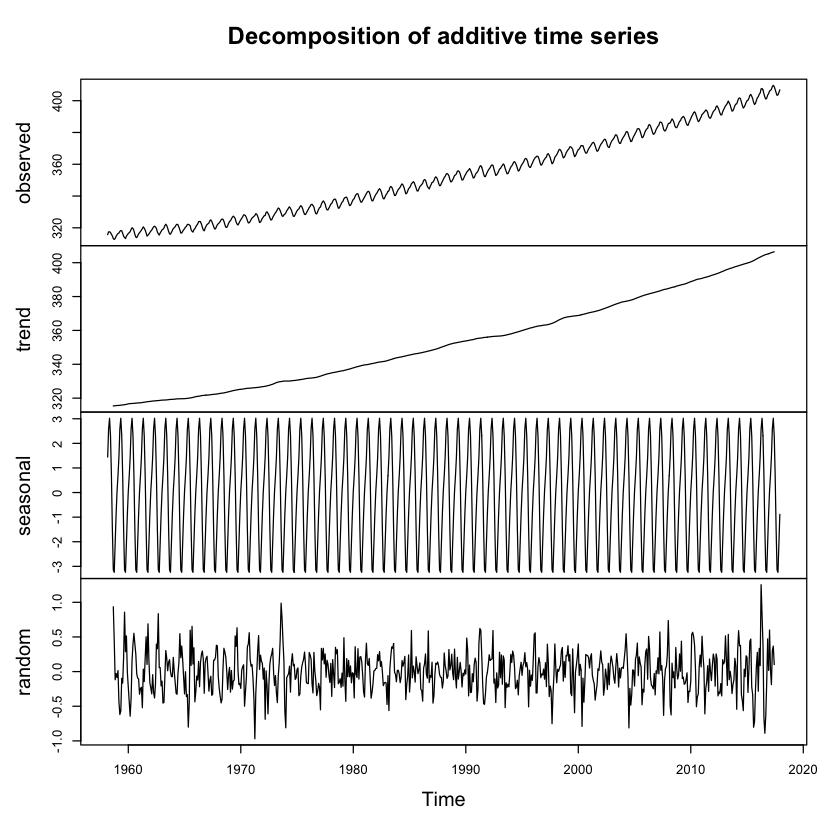

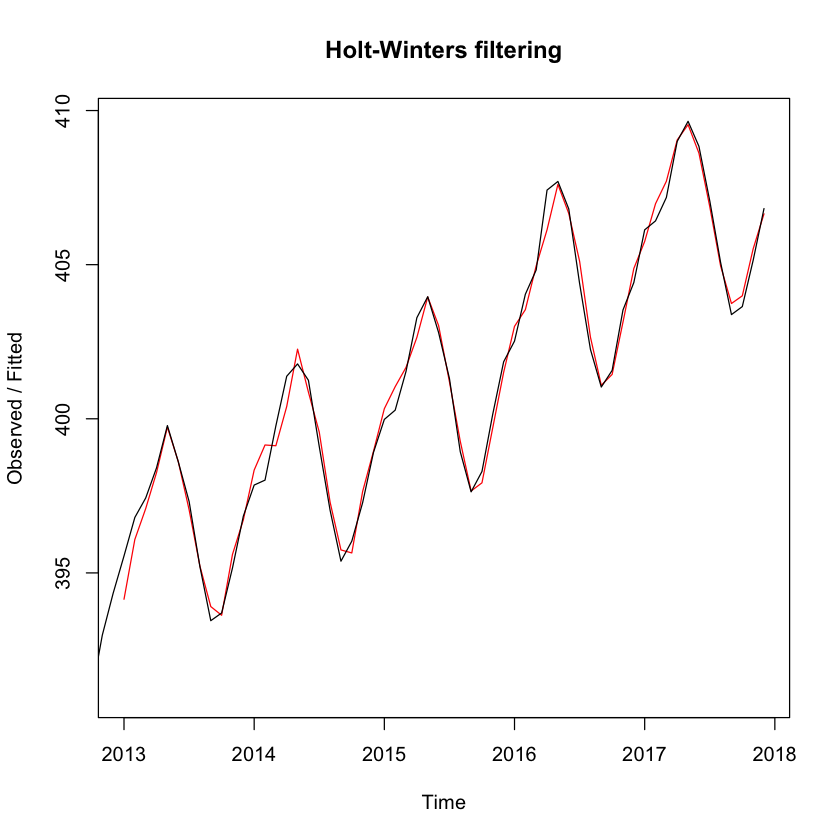

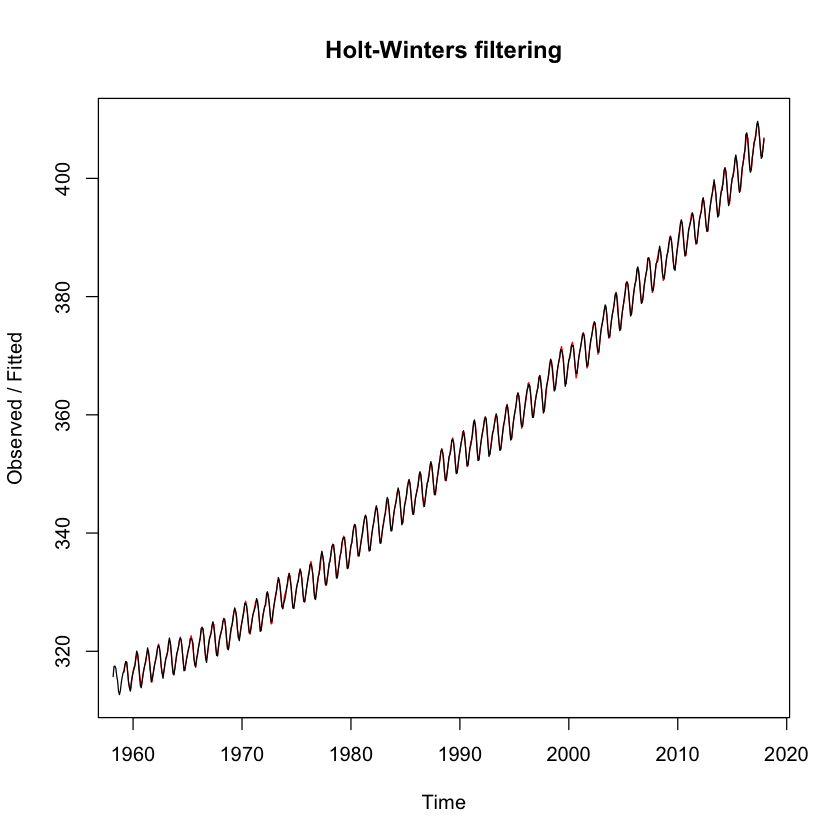

In [3]:
shortts = ts(df[647:718, 4], frequency = 12, start = c(2012, 1))  # only 2012-2017
fullts = ts(df[1:718,5], frequency = 12, start = c(1958, 3))      # 1953 - 2017
plot(decompose(fullts))
plot(HoltWinters(shortts))
plot(HoltWinters(fullts))

In [4]:
MAPE(HoltWinters(shortts)$fitted[,1], df[659:718, 4])
MAPE(HoltWinters(fullts)$fitted[,1], df[13:718,5])

[1] 0.0009131576

[1] 0.0007023404

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)   1660.28         0 *
McLeod-Li Q                Q ~ chisq(20)    665.96         0 *
Turning points T (T-477.3)/11.3 ~ N(0,1)       402         0 *
Diff signs S      (S-358.5)/7.7 ~ N(0,1)       351    0.3326
Rank P      (P-128701.5)/3209.9 ~ N(0,1)    131805    0.3336


Series: residuals 
ARIMA(1,0,1)(2,0,0)[12] with zero mean 

Coefficients:
         ar1      ma1    sar1    sar2
      0.8506  -0.2012  0.1318  0.0609
s.e.  0.0261   0.0486  0.0387  0.0409

sigma^2 estimated as 0.09102:  log likelihood=-157.06
AIC=324.11   AICc=324.2   BIC=347

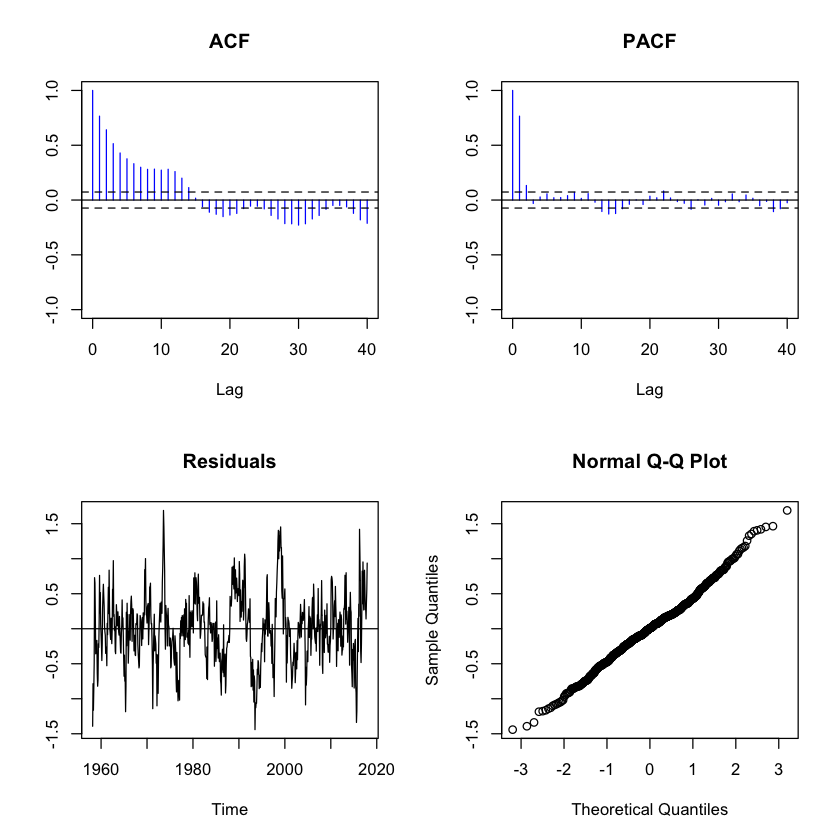

In [5]:
residuals = fullts - season(fullts,12) - trend(fullts,12)
test(residuals)
auto.arima(residuals)

In [14]:
fullts = ts(df[1:nrow(df),5], frequency = 12, start = c(1958, 3))

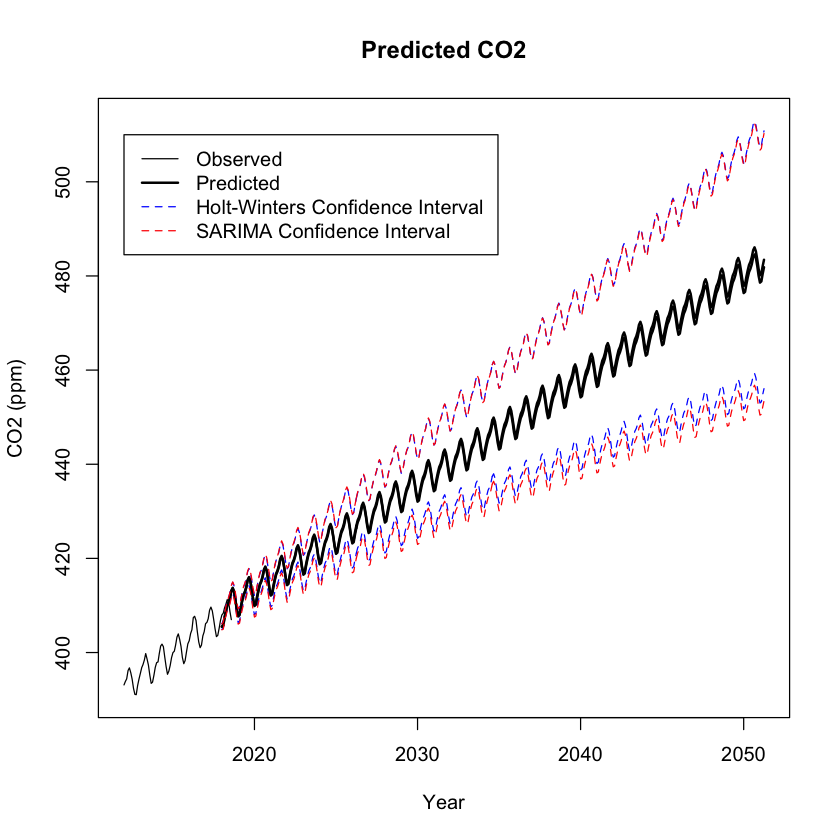

In [20]:
pred = data.frame(predict(stats::HoltWinters(fullts), n.ahead = 400, prediction.interval = 1))
pred$date = seq(as.Date("2018-01-01"), by = "month", length.out = nrow(pred))

sarima = stats::arima(fullts, order = c(2,1,0), seasonal = list(order = c(2,1,1), period = 12))
sarimapred = data.frame(predict(sarima, n.ahead = 400, prediction.interval = 1))
sarimapred[,3:4] = cbind(sarimapred[,1] - 2*sarimapred[,2], sarimapred[,1] + 2*sarimapred[,2])
sarimapred$date = seq(as.Date("2018-01-01"), by = "month", length.out = nrow(sarimapred))

plot(df[647:726,8], df[647:726, 4], type = "l", 
     main = "Predicted CO2", xlab = "Year", ylab = "CO2 (ppm)", 
     xlim = range(pred[,4], df[647:726,8]), ylim = range(pred[,2],df[647:726, 4] ))
matlines(pred[,4], pred[,-4], lwd = c(2,1,1), lty = c(1,2,2), col = c("black", "blue", "blue"))
matlines(sarimapred[,5], sarimapred[,c(1,3,4)], lwd = c(2,1,1), lty = c(1,2,2), col = c("black", "red", "red"))
legend(as.Date("2012-01-1"), 510, legend =c("Observed", "Predicted", "Holt-Winters Confidence Interval", "SARIMA Confidence Interval"), 
      col = c("black", "black", "blue", "red"), lty = c(1,1,2,2), lwd = c(1,2,1,1))

In [38]:
pred$date[pred$fit > 450][1]
pred$date[pred$lwr > 450][1]
pred$date[pred$upr > 450][1]

# sarimapred
sarimapred$date[sarimapred$pred > 450][1]
sarimapred$date[sarimapred$V3 > 450][1]
sarimapred$date[sarimapred$V4 > 450][1]

[1] "2035-07-01"

[1] "2043-09-01"

[1] "2031-07-01"

[1] "2035-08-01"

[1] "2045-08-01"

[1] "2031-07-01"

In [18]:
MAPE(pred[1:8,1],df[719:726,5])
MAPE(sarimapred[1:8,1],df[719:726,5])


[1] 0.0006580005

[1] 0.0008661407

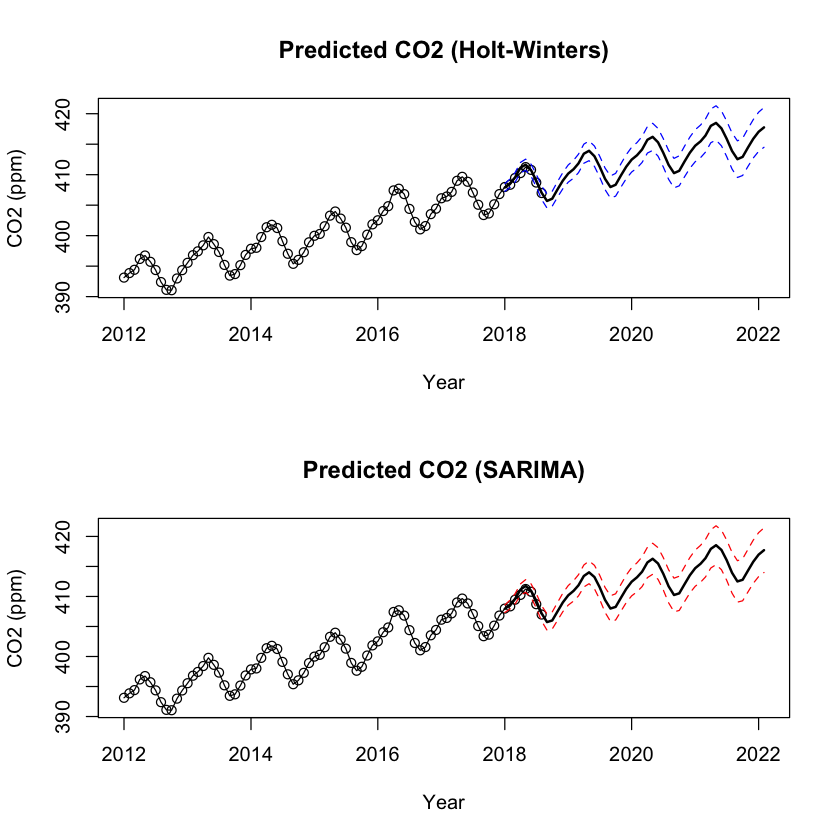

In [7]:
par(mfrow = c(2,1))

plot(df[647:726,8], df[647:726, 4], type = "o", 
     main = "Predicted CO2 (Holt-Winters)", xlab = "Year", ylab = "CO2 (ppm)", 
     xlim = range(pred[,4], df[647:726,8]), ylim = range(pred[,2],df[647:726, 4] ))
matlines(pred[,4], pred[,-4], lwd = c(2,1,1), lty = c(1,2,2), col = c("black", "blue", "blue"))
plot(df[647:726,8], df[647:726, 4], type = "o", main = "Predicted CO2 (SARIMA)",
     xlab = "Year", ylab = "CO2 (ppm)", xlim = range(sarimapred[,5], df[647:726,8]), 
     ylim = range(sarimapred[,4],df[647:726, 4] ))
matlines(sarimapred[,5], sarimapred[,c(1,3,4)], lwd = c(2,1,1), lty = c(1,2,2), col = c("black", "red", "red"))